# Task2:乙醇销售数据回归

In [152]:
# 导入库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
torch.set_default_tensor_type(torch.DoubleTensor)

In [153]:
device = torch.device('cuda:2')

### 数据处理

In [154]:
# 读取原始文件，并设置日期为索引
data = pd.read_csv('alcohol.csv', index_col='DATE')
# 将data_index设置为时间格式
data.index = pd.to_datetime(data.index)

# 转为 array
series = np.array(data)

### 数据可视化

In [155]:
# 定义绘制函数
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    # 设置图例
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

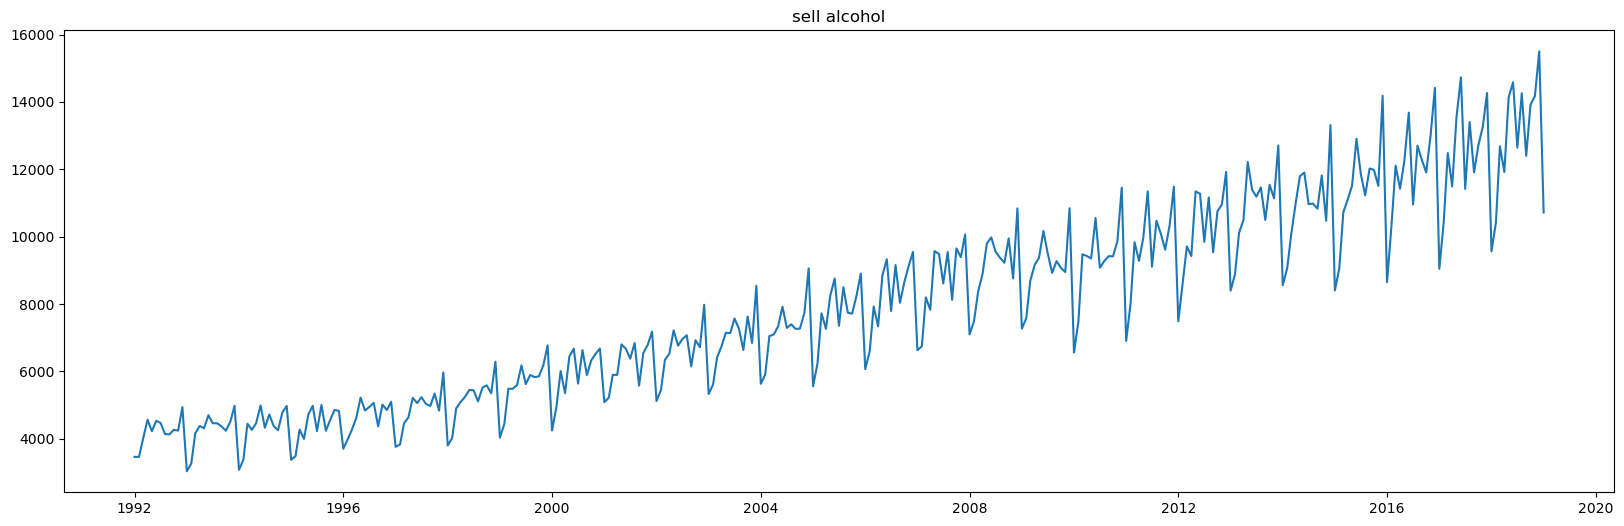

In [156]:
import matplotlib.ticker as mticker

fig,ax = plt.subplots(figsize=(20, 6))
plt.plot(data.index,series)
plt.title('sell alcohol')
plt.show()

### 划分训练集、测试集、batch

In [157]:
def train_test_split(series, split_prop): # split_prop: 训练集占比 
    train = series[:int(len(series)*split_prop)]
    test = series[int(len(series)*split_prop):]
    return train, test

# 将数据划分为指定大小的batch
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

### 滑窗、划分特征/标签函数

In [158]:
# 滑窗、打乱
def data_process(train, test, window_size):
    # 将数据转为tensor，并进行滑窗，得到短序列
    train_tensor = torch.from_numpy(train)
    print('滑窗之前：', train_tensor.shape)
    train_tensor = train_tensor.squeeze()
    train_window_split = train_tensor.unfold(0, window_size, 1)
    print('滑窗之后：', train_window_split.shape)
    train_set = train_window_split.numpy()

    test_tensor = torch.from_numpy(test)
    print('滑窗之前：', test_tensor.shape)
    test_tensor = test_tensor.squeeze()
    test_window_split = test_tensor.unfold(0, window_size, 1)
    print('滑窗之后：', test_window_split.shape)
    test_set = test_window_split.numpy()

    # 打乱训练集数据
    train_temp1 = train_set.tolist()
    random.shuffle(train_temp1)
    train_templ2 = np.array(train_temp1)

    # 将短序列分为feature、label
    train_feature_array = train_templ2[:, :window_size-1]
    train_label_array = train_templ2[:, window_size-1:]
    test_feature_array = test_set[:, :window_size-1]
    test_label_array = test_set[:, window_size-1:]

    # 将 ndarray转为tensor
    train_feature_tensor = torch.from_numpy(train_feature_array).double()
    train_label = torch.from_numpy(train_label_array).double()
    test_feature_tensor = torch.from_numpy(test_feature_array).double()
    test_label = torch.from_numpy(test_label_array).double()

    # 扩展数据维度，符合 CNN 输入(样本数，通道数，特征数)
    train_feature = train_feature_tensor.reshape(train_feature_tensor.shape[0], 1, train_feature_tensor.shape[1])
    test_feature = test_feature_tensor.reshape(test_feature_tensor.shape[0], 1, test_feature_tensor.shape[1])

    return train_feature, train_label, test_feature, test_label

### 数据处理

In [159]:
split_prop = 0.7
train, test = train_test_split(series, split_prop)
window_size = 13
# 数据处理
train_feature, train_label, test_feature, test_label = data_process(train, test, window_size)
# 分别输出训练集、测试集的特征和标签
print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

滑窗之前： torch.Size([227, 1])
滑窗之后： torch.Size([215, 13])
滑窗之前： torch.Size([98, 1])
滑窗之后： torch.Size([86, 13])
torch.Size([215, 1, 12])
torch.Size([215, 1])
torch.Size([86, 1, 12])
torch.Size([86, 1])


### 复现一维卷积神经网络

In [160]:
# 定义卷积神经网络
class ConvModule1(nn.Module):
    def __init__(self):
        super(ConvModule1, self).__init__()
        # 一层一维卷积
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # 将输出通道变为单值
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out = self.conv1(x) # 一维卷积
        out = F.max_pool1d(out, kernel_size=2, padding=1) # 最大池化
        out = self.conv2(out) # 一维卷积
        out = F.max_pool1d(out, 3) # 最大池化
        out = out.squeeze()
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
# 构建网络
net = ConvModule1().to(device)

In [161]:
# 定义损失函数-均方误差
def square_loss(feature, label):
    return (net(feature) - label)**2/2

### 参数初始化

In [162]:
for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)

lr = 0.001
num_epochs = 100
batch_size = 128
loss = square_loss
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### 训练模型

In [163]:
train_loss, test_loss = [], []
# 模型训练
for epoch in range(num_epochs):
    train_l, test_l = 0.0, 0.0
    for X,y in data_iter(batch_size, train_feature, train_label):
        X, y = X.to(device), y.to(device)
        l = loss(X, y).sum() # 计算 loss
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward() # 反向传播
        optimizer.step() # 更新参数
    
    train_l = loss(train_feature.to(device), train_label.to(device)).mean().detach().item()
    test_l = loss(test_feature.to(device), test_label.to(device)).mean().detach().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss: %f, test loss: %f' % (epoch+1, train_l, test_l))

epoch 1, train loss: 23173110.083873, test loss: 67650781.472008
epoch 2, train loss: 23163486.733388, test loss: 67622675.748769
epoch 3, train loss: 23142476.259183, test loss: 67561327.509403
epoch 4, train loss: 23102103.472563, test loss: 67443412.273927
epoch 5, train loss: 23030400.830747, test loss: 67233937.297324
epoch 6, train loss: 22909668.335465, test loss: 66881227.790960
epoch 7, train loss: 22715955.678113, test loss: 66315413.068976
epoch 8, train loss: 22417593.500993, test loss: 65444103.021574
epoch 9, train loss: 21973428.095420, test loss: 64147344.990880
epoch 10, train loss: 21332516.063275, test loss: 62276625.696023
epoch 11, train loss: 20434169.346067, test loss: 59655138.124367
epoch 12, train loss: 19210217.405362, test loss: 56084063.417056
epoch 13, train loss: 17591501.504260, test loss: 51361918.840315
epoch 14, train loss: 15520213.629356, test loss: 45320618.999060
epoch 15, train loss: 12970093.456055, test loss: 37883889.042899
epoch 16, train los

### 绘制损失函数曲线

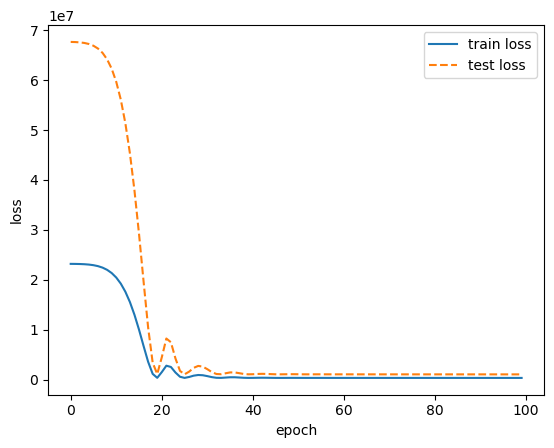

In [164]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, test_loss, label='test loss', linestyle='--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 预测并对比

In [165]:
def predict(x):
    temp = torch.from_numpy(x)
    x_tensor = temp.reshape(1, 1, window_size-1) # 一次只输入一个样本
    return net(x_tensor)

In [166]:
time = data.index.to_list()

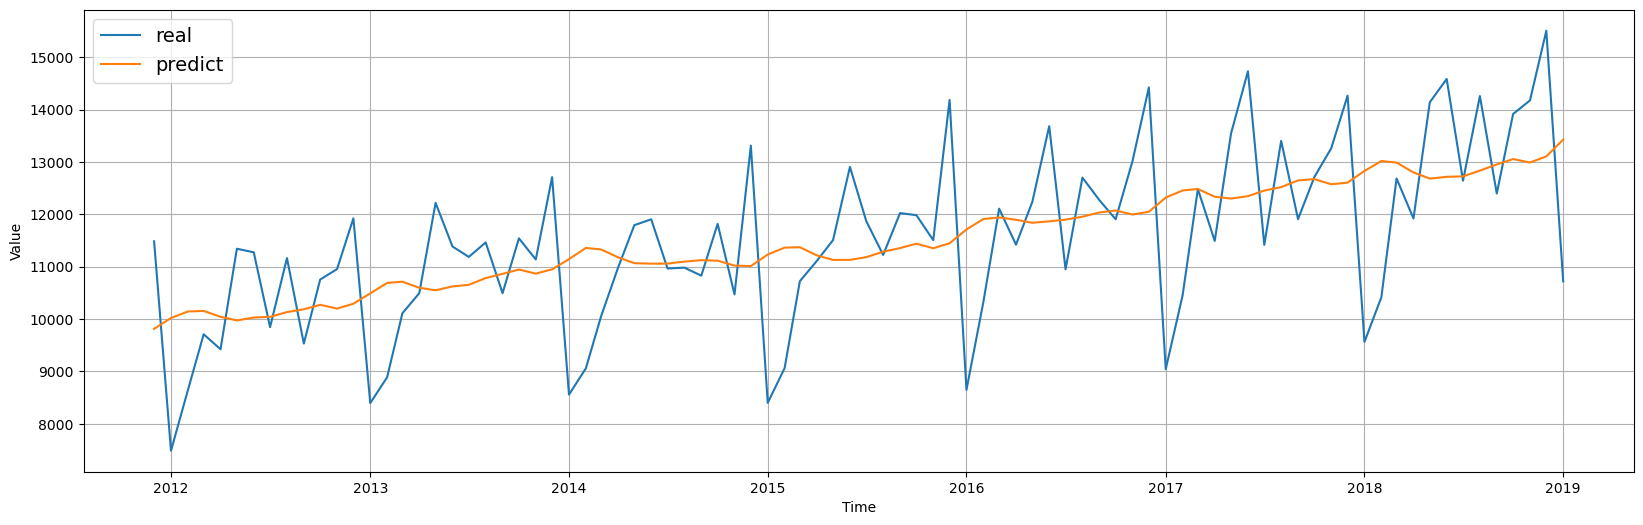

In [167]:
net = net.to('cpu') # 把 net单独拆下来，放到cpu上；要不然就得把数据搬到 GPU 上

test_predict = []
split_point = int(split_prop * len(series))
test_time = time[split_point+window_size-1:] # 测试集时间 
test_true = series[split_point+window_size-1:] # 测试集真实值
test_predict = net(test_feature).squeeze().tolist() # 测试集预测值

plt.figure(figsize=(20, 6))
plot_series(test_time, test_true, label='real')
plot_series(test_time, test_predict, label='predict')
plt.show()

In [168]:
from sklearn.metrics import mean_absolute_error as mae

print('MAE:', mae(test_true, test_predict))

MAE: 1135.5150656931642


由此可见，卷积神经网络和前馈神经网络一样，对该数据的拟合效果很差。

下面对网络结构进行调整

### 使用 RNN

In [331]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # 计算展平后的大小
        self.flatten_size = 128 * (input_length // 8)  # 假设输入长度为 input_length
        
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [332]:
net = DeepCNN().to(device)

### 参数初始化

In [333]:
for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)

lr = 0.005
num_epochs = 1000
batch_size = 64
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### 训练模型

In [334]:
train_loss, test_loss = [], []
# 模型训练
for epoch in range(num_epochs):
    train_l, test_l = 0.0, 0.0
    for X,y in data_iter(batch_size, train_feature, train_label):
        X, y = X.to(device), y.to(device)
        # print(X.shape, y.shape)
        y_hat = net(X)
        l = loss(y, y_hat).sum() # 计算 loss
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward() # 反向传播
        optimizer.step() # 更新参数
    
    train_l = loss(net(train_feature.to(device)), train_label.to(device)).mean().detach().item()
    test_l = loss(net(test_feature.to(device)), test_label.to(device)).mean().detach().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss: %f, test loss: %f' % (epoch+1, train_l, test_l))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x64 and 1536x64)

### 绘制损失函数曲线

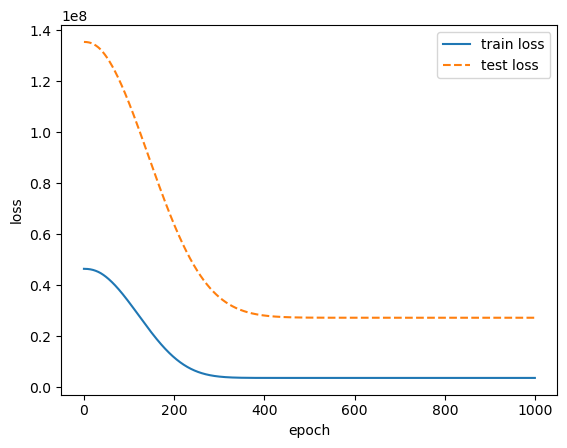

In [318]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, test_loss, label='test loss', linestyle='--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 预测并对比

In [319]:
def predict(x):
    temp = torch.from_numpy(x)
    x_tensor = temp.reshape(1, 1, window_size-1) # 一次只输入一个样本
    return net(x_tensor)

In [320]:
time = data.index.to_list()

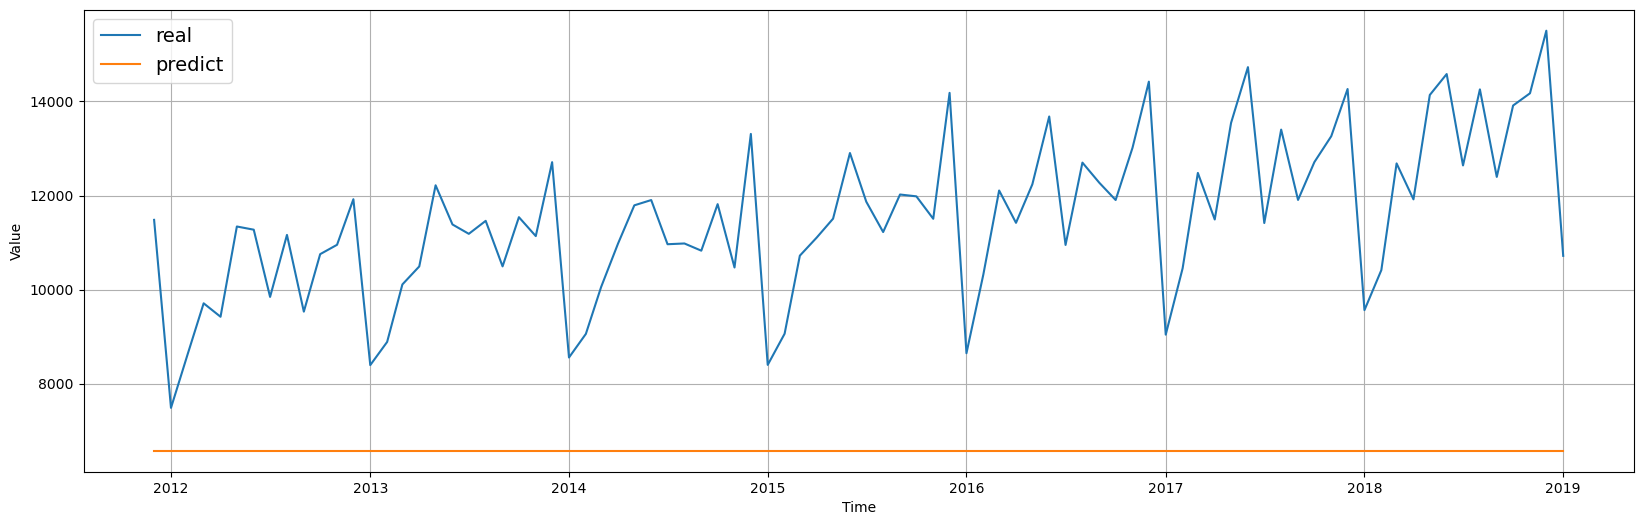

In [321]:
# net = net.to('cpu') # 把 net单独拆下来，放到cpu上；要不然就得把数据搬到 GPU 上

test_predict = []
split_point = int(split_prop * len(series))
test_time = time[split_point+window_size-1:] # 测试集时间 
test_true = series[split_point+window_size-1:] # 测试集真实值
test_predict = net(test_feature.to(device)).detach().squeeze().tolist() # 测试集预测值

plt.figure(figsize=(20, 6))
plot_series(test_time, test_true, label='real')
plot_series(test_time, test_predict, label='predict')
plt.show()

In [322]:
from sklearn.metrics import mean_absolute_error as mae

print('MAE:', mae(test_true, test_predict))

MAE: 4937.0254891416635
